<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74105 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

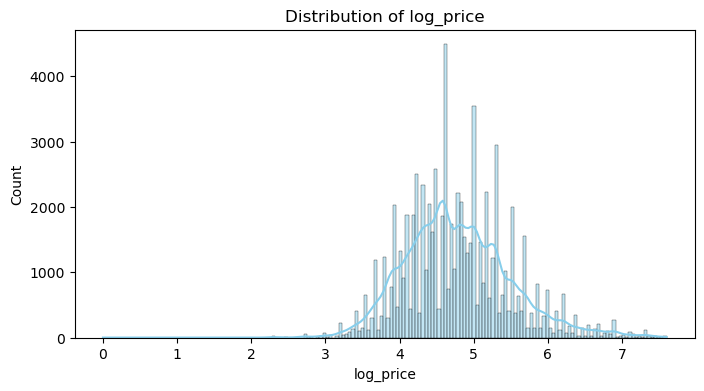

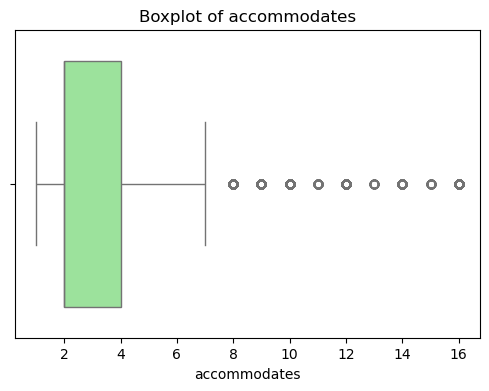

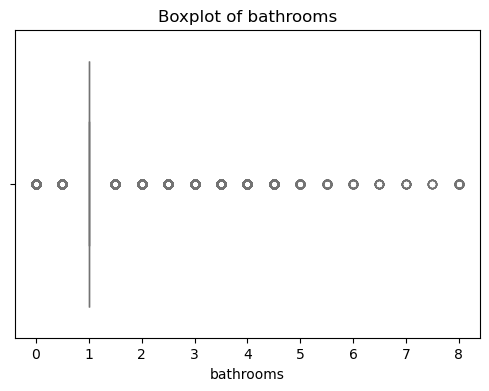

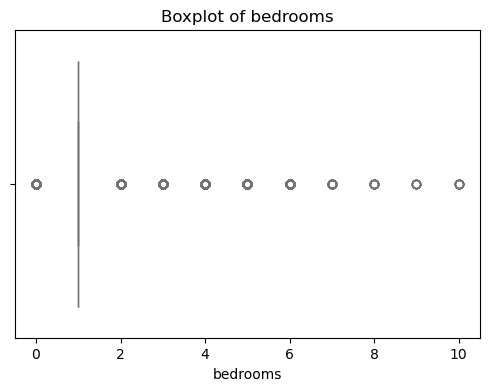

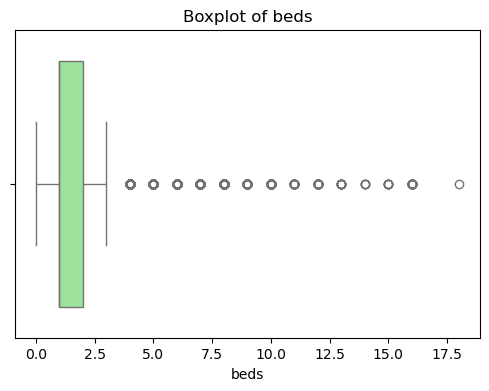

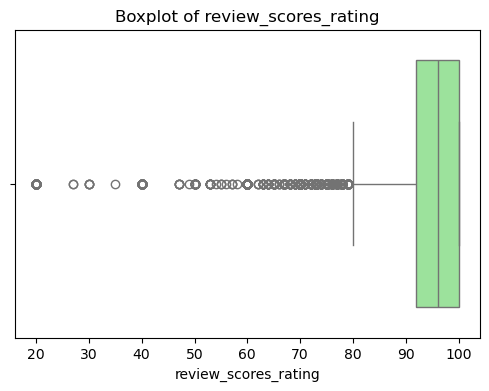

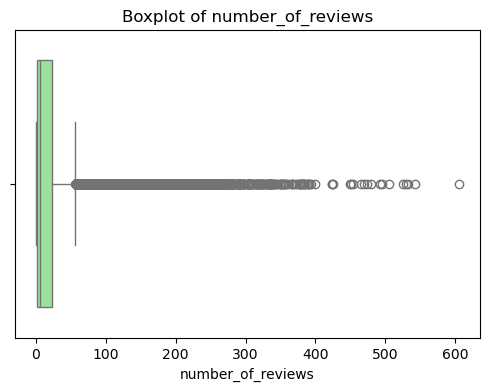


Final dataset shape:
(74111, 686)


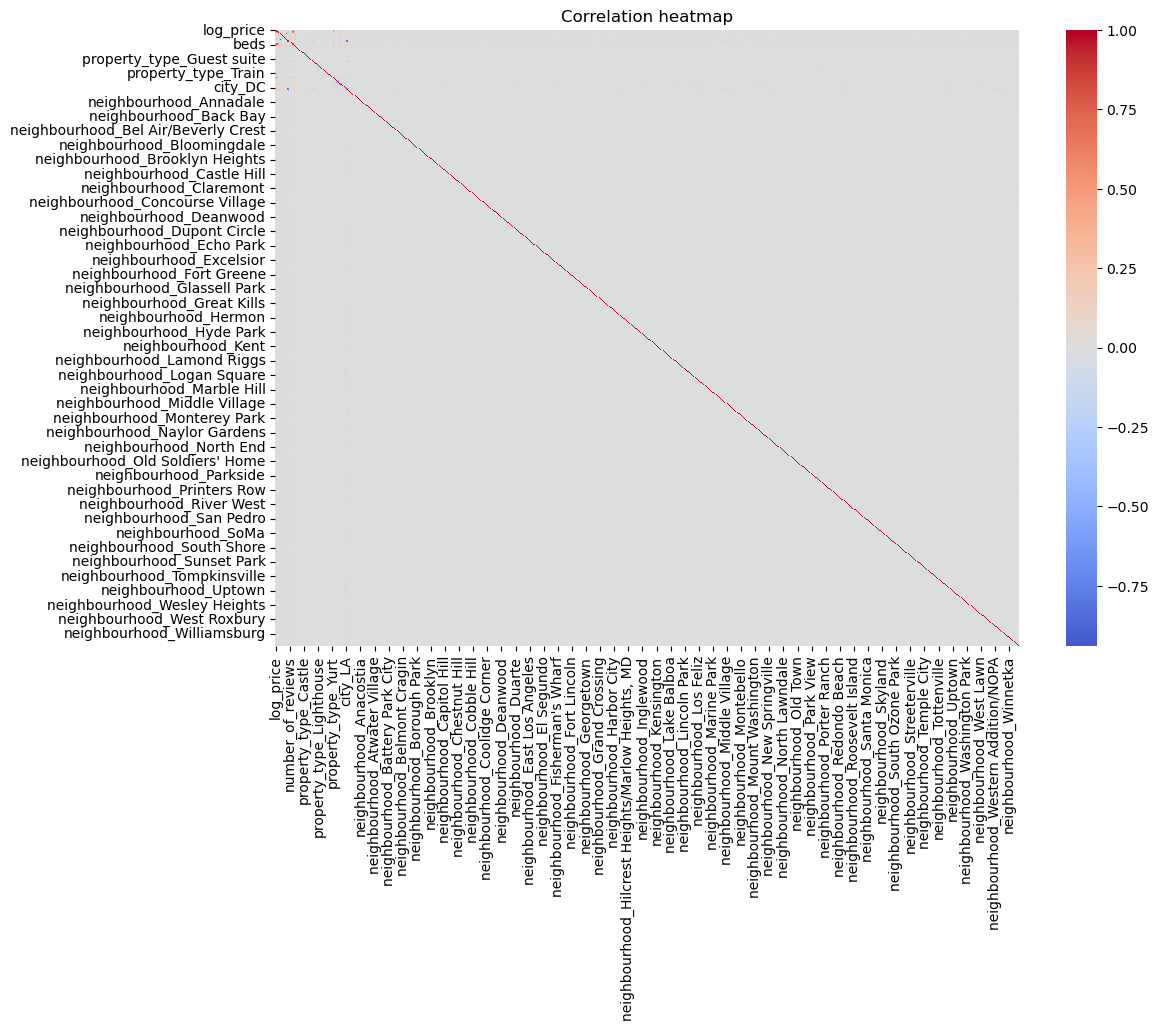

In [14]:
# Step 1: Data Exploration and Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel("D:/Download/Airbnb_data.xlsx")

# --- Data overview ---
print(df.info())
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())

# --- Visualize distribution of log_price ---
plt.figure(figsize=(8,4))
sns.histplot(df['log_price'], kde=True, color='skyblue')
plt.title('Distribution of log_price')
plt.show()

# --- Boxplots for numerical variables ---
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews']
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.show()

# --- Handle missing values ---
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['beds'] = df['beds'].fillna(df['beds'].median())
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())

# --- Parse dates safely ---
date_cols = ['first_review', 'last_review', 'host_since']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
        df[col] = df[col].fillna(df[col].min())

# --- Feature engineering ---
df['num_amenities'] = df['amenities'].apply(lambda x: len(str(x).split(',')))
df['desc_length'] = df['description'].apply(lambda x: len(str(x)))
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: 1 if str(x).upper() in ['TRUE', '1'] else 0)

# Convert host_response_rate safely
if 'host_response_rate' in df.columns:
    df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%','', regex=False)
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
    df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())

# Convert boolean columns to 0/1
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['t','true','1'] else 0)

# Drop irrelevant columns
drop_cols = ['id', 'description', 'name', 'thumbnail_url', 'zipcode', 'amenities']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# --- Encode categorical variables ---
categorical_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'neighbourhood']
df_encoded = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

print("\nFinal dataset shape:")
print(df_encoded.shape)

# --- Visualize correlation heatmap ---
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', center=0)
plt.title('Correlation heatmap')
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_csv(r"D:\Download\Airbnb_data - airbnb_data.csv")

# Feature Engineering
df['desc_length'] = df['description'].astype(str).apply(len)
df['num_amenities'] = df['amenities'].astype(str).apply(lambda x: len(x.split(',')))
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].astype(str).str.replace('%',''), errors='coerce').fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].astype(str).apply(lambda x: 1 if x.lower() in ['true','1'] else 0)

# Convert boolean columns
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    df[col] = df[col].astype(str).apply(lambda x: 1 if x.lower() in ['t','true'] else 0)

# Fill missing numerical values
num_cols = ['bathrooms','bedrooms','beds','review_scores_rating','number_of_reviews']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())

# Encode categorical variables
cat_cols = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Prepare features and target
X = df_encoded.drop(['id','log_price','name','description','thumbnail_url','zipcode',
                     'amenities','first_review','last_review','host_since'], axis=1, errors='ignore')
y = df_encoded['log_price']

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")


Test RMSE: 0.3899
Test MAE: 0.2804
Test R²: 0.7041
